# Solving Harold Zurcher model

“Dynamic programming and structural estimation” mini course

Fedor Iskhakov

Reading: **Rust (1987) "Optimal Replacement of GMC Bus Engines: An Empirical Model of Harold Zurcher"**

## Bellman equation for the Harold Zurcher problem

\begin{equation}
V(x) = \max_{d\in C} \big\{ u(x,d) + \beta E\big[ V(x')\big|x,d\big] \big\}
\end{equation}

$C = \{0,1\} = \{\text{keep},\text{replace}\}$

\begin{equation}
    \ u(x_{t},d_t,\theta_1)=\left \{ 
    \begin{array}{ll}
        -RC-c(0,\theta_1) & \text{if }d_{t}=1 \\ 
        -c(x_{t},\theta_1) & \text{if }d_{t}=0%
    \end{array} \right.
\end{equation}

$x_{t+1} \sim F(x_t,d_t)$

## Transition matrix for mileage when $d=0$

$\Pi(d=0)_{n x n} = 
\begin{pmatrix}
\pi_0 & \pi_1 & \pi_2 & 0 & \cdot & \cdot & \cdot & 0 \\
0 & \pi_0 & \pi_1 & \pi_2 & 0 & \cdot & \cdot & 0 \\
0 & 0 &\pi_0 & \pi_1 & \pi_2 & 0 & \cdot & 0 \\
\cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot \\
0 & \cdot & \cdot & 0 & \pi_0 & \pi_1 & \pi_2 & 0 \\
0 & \cdot & \cdot & \cdot & 0 & \pi_0 & \pi_1 & \pi_2 \\
0 & \cdot & \cdot & \cdot & \cdot  & 0 & \pi_0 & 1-\pi_0 \\
0 & \cdot & \cdot & \cdot & \cdot & \cdot  & 0 & 1
\end{pmatrix}$


## Transition matrix for mileage, $d=1$

$\Pi(d=1)_{n x n} = 
\begin{pmatrix}
\pi_0 & \pi_1 & \pi_2 & 0 & \cdot & \cdot & \cdot & 0 \\
\pi_0 & \pi_1 & \pi_2 & 0 & \cdot & \cdot & \cdot & 0 \\
\pi_0 & \pi_1 & \pi_2 & 0 & \cdot & \cdot & \cdot & 0 \\
\cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot \\
\pi_0 & \pi_1 & \pi_2 & 0 & \cdot & \cdot & \cdot & 0 \\
\pi_0 & \pi_1 & \pi_2 & 0 & \cdot & \cdot & \cdot & 0 \\
\pi_0 & \pi_1 & \pi_2 & 0 & \cdot & \cdot & \cdot & 0 \\
\end{pmatrix}$

## Bellman operator

Bellman equation can be written as a fixed point equation of the **Bellman operator** in the functional space

$$
T(V)(x) \equiv \max_{d \in C} \big\{ u(x,d) + \beta E\big[ V(x') \big|x,d\big] \big\}
$$

The Bellman equations is then $ V(x) = T({V})(x) $, with the
solution given by the fixed point $ T({V}) = V $

## Bellman equation in expected value function space

Let $EV(x,d)$ denote the expected value function, then we have

\begin{equation}
EV(x,d) = \int_{X} \log \big( \exp[u(x',0) + \beta EV(x',0)] + \exp[u(x',1) + \beta EV(x',1)] \big) \pi(x'|x,d) dx'
\end{equation}

In the form of the operator

$$
T^*(EV)(x,d) \equiv \int_{X} \log \big( \exp[u(x',0) + \beta EV(x',0)] + \exp[u(x',1) + \beta EV(x',1)] \big) \pi(x'|x,d) dx'
$$

Solution to the Bellman functional equation $EV(x,d)$ is also a fixed point of $T^*$ operator, $T^*(EV)(x,d)=EV(x,d)$




## How to solve Bellman equation

**Value function iterations (VFI)** 
also known as successive approximations

1. Start with arbitrary guess for $EV(x,d)$
2. Apply $T^*$ operator
3. Check for (uniform) convergence
4. If not converged to a given level of tolerance, return to step 2, otherwise finish.

## Questions to think about

- What determines the speed of convergence of the VFI algorithm?
- How can we improve the convergence speed?

In [283]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class zurcher():
    '''Harold Zurcher bus engine replacement model class, VFI version'''

    def __init__(self, 
                 n = 175, # default parameter values
                 mmax = 450,
                 p = [0.0937,0.4475,0.4459,0.0127],
                 RC = 11.7257,
                 c = 2.45569,
                 beta = 0.9999):
        '''Initializator for the zurcher class'''
        assert sum(p)<=1.0,'sum of transision probability parameters must not exceed unity'
        self.p = p        # parameters for transision probabilities
        self.n = n        # set number of grid points on the state space
        self.mmax = mmax  # maximum milage
        self.RC = RC      # replacement cost
        self.c = c        # cost function parameter
        self.beta = beta  # discount factor

    @property
    def n(self):
        '''Dimension getter'''
        return self.__n # internal dimension variable

    @n.setter
    def n(self,n):
        '''Dimension setter, updaing the grid and transision probabilities'''
        self.__n = n
        # create gid for the set dimension
        self.grid = np.arange(n) # 0,..,n-1 index of grid points
        # create transition prob for the set dimension
        p = self.p # "copy" the list of parameters
        p.append(1.0-sum(p)) # add the last element to ensure 1.0 in sum
        self.P1,self.P2 = self.transition_probability(np.array(p)) # compute transision probabilities
        
    def __str__(self):
        '''String representation of the Zurcher model object'''
        # id() is unique identifier for the variable (reference), convert to hex
        return 'Zurcher bus engine replacement model with id=%s' % hex(id(self))
    
    def __repr__(self):
        '''Print for Zurcher model object'''
        return self.__str__()

    def transition_probability(self,p):
        '''Compute transition probability matrixes conditional on choice'''
        # conditional on d=0, no replacement
        P1 = np.full((self.n,self.n),0.0)
        for i in range(self.n):
            if i <= self.n-p.size:
                # lines where p vector fits entirely
                P1[i][i:i+p.size]=p
            else:
                P1[i][i:] = p[:self.n-p.size-i]
                P1[i][-1] = 1.0-P1[i][:-1].sum()
        # conditional on d=1, replacement
        P2 = np.full((self.n,self.n),0.0)
        for i in range(self.n):
            P2[i][:p.size]=p
        return P1,P2
        
    def bellman(self,ev0,output=0):
        ''' Bellman operator for the model
            Input: current approximation of the EV as column vector
                   output = type of output requested 
            Output: new approximation of EV
                    d=0 choice probability (if output>0)
                    Frechet derivative of Bellman operator (if output>1)
        '''
        # EV0 is current approximation of EV on the fixed grid
        # For d=0 it holds values for all mileages
        # For d=1 (replacement) we use the first value EV0[0]
        # So, instead of EV(x,d) for d=0,1, we can use only one vector!
        assert np.all(ev0.shape==(self.n,1)),'Expecting EV as column vector'
        x = self.grid.reshape((self.n,1)) # states (in the next period), column vector
        c = 0.001*self.c*x # maintenance cost in all states
        v0 = -c + self.beta*ev0 # value of not replacing
        v1 = -c[0] -self.RC + self.beta*ev0[0] # value of replacing
        # recenter the values for numerical stability of logsum !!!!!!!!!!!!!!!!
        maxv = np.maximum(v0,v1)
        logsum = maxv + np.log(np.exp(v0-maxv) + np.exp(v1-maxv))
        ev1 = self.P1 @ logsum # matrix multiplication, result as column vector
        if output == 0:
            return ev1
        # keep (no replacement) choice probability
        pk = 1/(1+np.exp(v1-v0))
        if output == 1:
            return ev1,pk
        # Frechet derivative
        dev1 = self.beta * self.P1 * pk.transpose()
        dev1[:,0] += self.beta * np.squeeze(self.P1 @ (1-pk))
        return ev1,pk,dev1

    def solve_vfi(self, maxiter=1000, tol=1e-6, callback=None):
        '''Solves the model using successive approximations (VFI)'''
        ev0 = np.full((self.n,1),0) # initial guess of EV
        for iter in range(maxiter):
            ev1,pk = self.bellman(ev0,output=1)
            stp = np.max(abs(ev1-ev0))
            if callback:
                if iter==0: stp0=1.0
                callback(iter,self,ev1,pk,stp,stp/stp0) # callback for making plots
            if stp < tol: 
                break
            ev0=ev1
            stp0=stp
        else:  # when i went up to maxiter
            print('No convergence: maximum number of iterations achieved!')
        return ev1,pk

    def solve_nk(self, maxiter=1000, tol=1e-6, callback=None):
        '''Solves the model using the Newton-Kantorovich algorithm'''
        ev0 = np.full((self.n,1),0) # initial guess of EV
        for iter in range(maxiter):
            ev1,pk,dev = self.bellman(ev0,output=2) # compute Frechet derivative
            ev1 = ev0 - np.linalg.inv(np.eye(self.n)-dev) @ (ev0 - ev1) # NK iteration
            stp = np.max(abs(ev1-ev0))
            if callback:
                if iter==0: stp0=1.0
                callback(iter,self,ev1,pk,stp,stp/stp0) # callback for making plots
            if stp < tol: 
                break
            ev0=ev1
            stp0=stp
        else:  # when i went up to maxiter
            print('No convergence: maximum number of iterations achieved!')
        ev1,pk = self.bellman(ev1,output=1) # compute choice probabilities after convergence
        return ev1,pk
    
    def solve_poly(self, 
                   maxiter=1000, 
                   tol=1e-10, 
                   sa_min=5,         # minimum number of contraction steps
                   sa_max=25,         # maximum number of contraction steps
                   switch_tol=0.05,  # tolerance of the switching rule
                   callback=None, 
                   verbose=False):
        '''Solves the model using the poly-algorithm'''
        if verbose: 
            print('Running solution polyalgorithm')
            print('%6s %2s %16s %16s'%('iter','','err','err/err'))
        ev0 = np.full((self.n,1),0) # initial guess of EV
        for iter in range(maxiter):
            if iter==0: stp0=1.0
            ev1,pk,dev = self.bellman(ev0,output=2) # SA step
            itertype='SA'
            if iter>=sa_min and iter>0: # maybe switch to NK?
                if abs(stp/stp0 - self.beta)<switch_tol or iter>=sa_max:
                    ev1 = ev0 - np.linalg.inv(np.eye(self.n)-dev) @ (ev0 - ev1) # NK step
                    itertype='NK'
            stp = np.max(abs(ev1-ev0))
            if verbose: 
                print('%6d %2s %16.10f %16.10f'%(iter,itertype,stp,stp/stp0))
            if callback:
                if iter==0: stp0=1.0
                callback(iter,self,ev1,pk,stp,stp/stp0) # callback for making plots
            if stp < tol: 
                break
            ev0=ev1
            stp0=stp
        else:  # when i went up to maxiter
            print('No convergence: maximum number of iterations achieved!')
        ev1,pk = self.bellman(ev1,output=1) # compute choice probabilities after convergence
        return ev1,pk
    
    
    def solve_show(self,solver='vfi',maxiter=1000,tol=1e-6,**kvargs):
        '''Illustrate solution'''
        fig1, (ax1,ax2) = plt.subplots(1,2,figsize=(14,8))
        ax1.grid(b=True, which='both', color='0.65', linestyle='-')
        ax2.grid(b=True, which='both', color='0.65', linestyle='-')
        ax1.set_xlabel('Mileage grid')
        ax2.set_xlabel('Mileage grid')
        ax1.set_title('Value function')
        ax2.set_title('Probability of keeping the engine')
        def callback(iter,mod,ev,pk,stp,dstp):
            if iter==0:
                print('%4s %16s %16s'%('iter','err','err(i)/err(i-1)'))
                print('-'*40)
            print('%4d %16.12f %16.12f'%(iter,stp,dstp))            
            ax1.plot(mod.grid,ev,color='k',alpha=0.25)
            ax2.plot(mod.grid,pk,color='k',alpha=0.25)
        if solver=='vfi':
            ev,pk = self.solve_vfi(maxiter=maxiter,tol=tol,callback=callback,**kvargs)
        elif solver=='nk':
            ev,pk = self.solve_nk(maxiter=maxiter,tol=tol,callback=callback,**kvargs)
        elif solver=='poly':
            ev,pk = self.solve_poly(maxiter=maxiter,tol=tol,callback=callback,**kvargs)
        else:
            print('Unknown solver')
            return None
        # add solutions
        ax1.plot(self.grid,ev,color='r',linewidth=2.5)
        ax2.plot(self.grid,pk,color='r',linewidth=2.5)
        plt.show()
        return ev,pk

In [284]:
# investigate how parts of the code work:
model = zurcher(RC=.5,n=12,p=[0.65,0.2,0.1]) # model instance
# # model = zurcher() # model instance
# print('Model grid:\n',model.grid)
# print(model) # string representation
# print('Transition probabilities conditional on not replacing:\n',model.P1)
# print('Transition probabilities conditional on replacing:\n',model.P2)
ev,pk=model.bellman(np.full((model.n,1),0),output=1)
print('Bellman one run:\n',ev)
print('Probability of keeping:\n',pk)

Bellman one run:
 [[0.47323702]
 [0.47170994]
 [0.47018428]
 [0.46866004]
 [0.46713722]
 [0.46561582]
 [0.46409584]
 [0.46257729]
 [0.46106015]
 [0.45962006]
 [0.45833254]
 [0.45734867]]
Probability of keeping:
 [[0.62245933]
 [0.62188206]
 [0.62130445]
 [0.62072649]
 [0.62014818]
 [0.61956954]
 [0.61899056]
 [0.61841124]
 [0.61783158]
 [0.61725158]
 [0.61667125]
 [0.61609059]]


iter              err  err(i)/err(i-1)
----------------------------------------
   0   0.417013120838   0.417013120838
   1   0.410453410702   0.984269775196
   2   0.401432540836   0.978022183200
   3   0.389068085350   0.969199169901
   4   0.372429729454   0.957235361826
   5   0.350755873527   0.941804173478
   6   0.323779726767   0.923091389778
   7   0.292117960011   0.902212015952
   8   0.257606114324   0.881856474399
   9   0.226234044246   0.878216904284
  10   0.201767600152   0.891853393792
  11   0.182377902842   0.903900837915
  12   0.166781299956   0.914481948510
  13   0.154079475471   0.923841434930
  14   0.143634116491   0.932207979370
  15   0.134971006506   0.939686265379
  16   0.127733959977   0.946380732305
  17   0.121652716854   0.952391336456
  18   0.116519229964   0.957802118830
  19   0.112168702457   0.962662579313
  20   0.108464303081   0.966974750579
  21   0.105308738821   0.970906886693
  22   0.102603446816   0.974310849830
  23   0.100285993589  

 221   0.047646870051   0.996999963346
 222   0.047503927948   0.996999968676
 223   0.047361414897   0.996999973334
 224   0.047219329587   0.996999977490
 225   0.047077670707   0.996999981133
 226   0.046936436954   0.996999984266
 227   0.046795627046   0.996999987283
 228   0.046655239678   0.996999989592
 229   0.046515273559   0.996999991416
 230   0.046375727433   0.996999993440
 231   0.046236600001   0.996999994617
 232   0.046097890015   0.996999995974
 233   0.045959596194   0.996999996723
 234   0.045821717301   0.996999997730
 235   0.045684252060   0.996999998059
 236   0.045547199249   0.996999998798
 237   0.045410557605   0.996999998995
 238   0.045274325896   0.996999999205
 239   0.045138502899   0.996999999560
 240   0.045003087367   0.996999999485
 241   0.044868078090   0.996999999668
 242   0.044733473844   0.996999999734
 243   0.044599273348   0.996999998351
 244   0.044465475358   0.996999996173
 245   0.044332078680   0.996999994341
 246   0.044199082335   0

 473   0.022346738227   0.997000000000
 474   0.022279698013   0.997000000000
 475   0.022212858919   0.997000000000
 476   0.022146220342   0.997000000000
 477   0.022079781681   0.997000000000
 478   0.022013542336   0.997000000000
 479   0.021947501709   0.997000000000
 480   0.021881659204   0.997000000000
 481   0.021816014226   0.997000000000
 482   0.021750566183   0.997000000000
 483   0.021685314485   0.997000000000
 484   0.021620258541   0.997000000000
 485   0.021555397766   0.997000000000
 486   0.021490731572   0.997000000000
 487   0.021426259378   0.997000000000
 488   0.021361980600   0.997000000000
 489   0.021297894658   0.997000000000
 490   0.021234000974   0.997000000000
 491   0.021170298971   0.997000000000
 492   0.021106788074   0.997000000000
 493   0.021043467710   0.997000000000
 494   0.020980337307   0.997000000000
 495   0.020917396295   0.997000000000
 496   0.020854644106   0.997000000000
 497   0.020792080174   0.997000000000
 498   0.020729703933   0

 709   0.010996931079   0.997000000000
 710   0.010963940285   0.997000000000
 711   0.010931048464   0.997000000000
 712   0.010898255319   0.997000000000
 713   0.010865560553   0.997000000000
 714   0.010832963871   0.997000000000
 715   0.010800464980   0.997000000000
 716   0.010768063585   0.997000000000
 717   0.010735759394   0.997000000000
 718   0.010703552116   0.997000000000
 719   0.010671441460   0.997000000000
 720   0.010639427135   0.997000000000
 721   0.010607508854   0.997000000000
 722   0.010575686327   0.997000000000
 723   0.010543959268   0.997000000000
 724   0.010512327390   0.997000000000
 725   0.010480790408   0.997000000000
 726   0.010449348037   0.997000000000
 727   0.010417999993   0.997000000000
 728   0.010386745993   0.997000000000
 729   0.010355585755   0.997000000000
 730   0.010324518998   0.997000000000
 731   0.010293545441   0.997000000000
 732   0.010262664804   0.997000000000
 733   0.010231876810   0.997000000000
 734   0.010201181180   0

 955   0.005251464668   0.997000000000
 956   0.005235710274   0.996999999999
 957   0.005220003143   0.997000000000
 958   0.005204343133   0.997000000000
 959   0.005188730104   0.997000000000
 960   0.005173163914   0.997000000000
 961   0.005157644422   0.997000000000
 962   0.005142171489   0.997000000000
 963   0.005126744974   0.997000000000
 964   0.005111364739   0.997000000000
 965   0.005096030645   0.997000000000
 966   0.005080742553   0.997000000000
 967   0.005065500326   0.997000000000
 968   0.005050303825   0.997000000000
 969   0.005035152913   0.997000000000
 970   0.005020047454   0.997000000000
 971   0.005004987312   0.997000000000
 972   0.004989972350   0.996999999999
 973   0.004975002433   0.997000000000
 974   0.004960077426   0.997000000001
 975   0.004945197193   0.997000000000
 976   0.004930361602   0.997000000000
 977   0.004915570517   0.997000000001
 978   0.004900823805   0.997000000000
 979   0.004886121334   0.997000000000
 980   0.004871462970   0

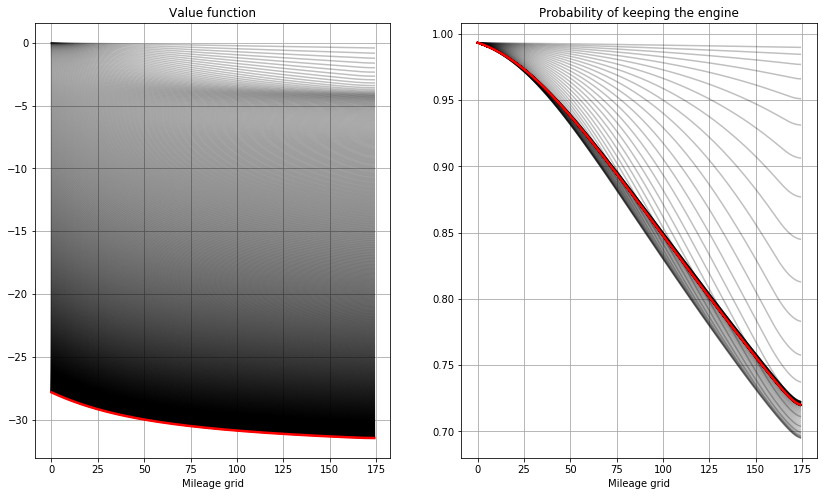

In [290]:
# solve Harold Zurcher model for different parameters
m = zurcher(beta=0.997,RC=5.0)
ev,pk = m.solve_show(maxiter=1000,tol=1e-8)

## Convergence of the VFI solution

- On one hand: **globally convergent (with single fixed point)**
- On the other hand: **very slowly approaching the fixed point when $\beta$ is close to one**

What can we do to make an improvement?


## Another approach

Remember that the solution of the problem (in terms of expected value function EV) is given by

$$
T^*(EV)(x,d)=EV(x,d)
$$

**Because this is an equation, we can try to solve it as an equation as well!**

## Refresher about the Newton method

Solve the equation $g(x)=0$, for now assume $x\in\mathbb{R}^1$

*Yet, it does work with system of non-linear equations as well!*

1. Start with some good guess $ x_0 $ not too far from the solution
2. Newton step
$$
x_{i+1} = x_i - \frac{g(x_i)}{g'(x_i)} 
$$
3. Iterate until convergence in some metric

### Derivation for Newton method using Taylor series expansion

$$
g(x) = \sum_{k=0}^{\infty} \frac{g^{(k)}(x_0)}{k!} (x-x_0)^k
$$

Take first two terms, assume $ g(x) $ is solution, and let
$ x_0=x_i $ and $ x=x_{i+1} $

$$
0 = g(x) = g(x_i) + g'(x_i) (x_{i+1}-x_i) \quad \Rightarrow \quad x_{i+1} = x_i - \frac{g(x_i)}{g'(x_i)}
$$

## Example: solve the equation

$$
g(x)=-4x^3 + 5x +1 = 0
$$


$$
\begin{eqnarray}
-4x^3 + 5x +1 &=& 0 \\
-4x(x^2-1) + x+1 &=& 0 \\
(x+1)(-4x^2+4x+1) &=& 0 \\
\big(x+1\big)\big(x-\frac{1}{2}-\frac{1}{\sqrt{2}}\big)\big(x-\frac{1}{2}+\frac{1}{\sqrt{2}}\big) &=& 0
\end{eqnarray}
$$

In [291]:
import numpy as np

def newton(fun, grad, x0, tol=1e-12, maxiter=100, callback=None):
    '''Newton method to solve fun(x)=0
       Callback function arguments (iter,x,x1,err)
    '''
    x=x0
    for iter in range(maxiter):
        x1 = x - fun(x)/grad(x)
        err = np.abs(x1-x)
        if callback:
            callback(iter,x,x1,err)
        if err < tol:
            return x1
        x = x1
    else:
        raise(RuntimeError('Failed to converge, increase maxiter'))

In [292]:
def callback_function(iter,x,x1,err):
    if iter==0:
        print('%4s %16s %16s %6s'%('iter','x','x1','err'))
        print('-'*50)
    print('%4d %16.12f %16.12f %6.2e'%(iter,x,x1,np.abs(x-x1)))

In [293]:
g = lambda x: -4*x**3+5*x+1
h = lambda x: -12*x**2+5    # gradient
x0 = 2.5 
root = newton(g,h,x0,tol=1e-9,callback=callback_function)
print('Solution is ',root)

iter                x               x1    err
--------------------------------------------------
   0   2.500000000000   1.800000000000 7.00e-01
   1   1.800000000000   1.406611570248 3.93e-01
   2   1.406611570248   1.241257260269 1.65e-01
   3   1.241257260269   1.208382830275 3.29e-02
   4   1.208382830275   1.207108666071 1.27e-03
   5   1.207108666071   1.207106781191 1.88e-06
   6   1.207106781191   1.207106781187 4.12e-12
Solution is  1.2071067811865475


In [294]:
import matplotlib.pyplot as plt
def show_newton(fun,grad,x0,xlim=[0,1],steps=10,**kwargs):
    '''Illustration for the Newton method'''
    xd = np.linspace(xlim[0],xlim[1],1000)
    graph = [xd,fun(xd)]
    def show(iter,x,x1,err):
        '''callback to make plots'''
        if iter >= steps: return
        fig1, ax1 = plt.subplots(1,1,figsize=(10,8))
        ax1.plot(xlim,[0,0],c='grey')
        ax1.plot(graph[0],graph[1],c='red')
        fn = fun(x)
        ax1.scatter(x,0,c='green')
        ax1.plot([x,x],[0,fn],c='grey')
        if x!=x1:
            l = lambda z: fn*(z - x1)/(x-x1)
            ax1.plot(graph[0],l(graph[0]),c='blue')
        ax1.scatter(x1,0,c='blue')
        ax1.set_xlim(xlim)
        ax1.grid(True)
        ax1.set_title('Step %d'%iter)
        plt.show()
    return newton(fun,grad,x0,callback=show,**kwargs)

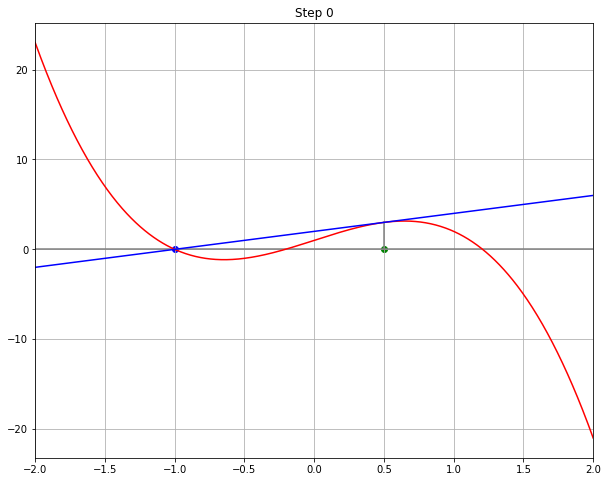

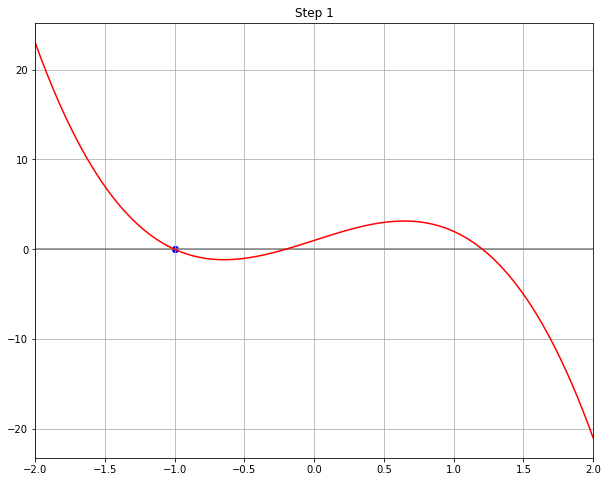

Solution is  -1.0


In [296]:
x0 = 2.5 # try 1, 0.5 (!), 0.63, -0.63, -0.65
x0 = 0.5
root = show_newton(g,h,x0,tol=1e-8,xlim=[-2,2])
print('Solution is ',root)

## Questions to think about

- Does Newton method always converge?
- Which solution does the Newton method converge to?
- What determines the speed of convergence?

## Back to Harold Zurcher

Let's apply Newton method for the equation

$$
EV(x,d) = \Gamma(EV)(x,d) \quad\Leftrightarrow\quad (I - \Gamma)(EV)(x,d)=\mathbb{0}
$$

where the new operator is the difference between the identity operator $I$ and Bellman operator $\Gamma = T^*$, and
$\mathbb{0}$ is zero function

**Quadratic convergence!**

$$
|| EV_{k+1} - EV* || < c ||EV_{k} - EV*||^2
$$

## Newton-Kantorovich method

Kantorovich extended Newton method to functional equations.

The NK iteration is 

$$
EV_{k+1} = EV_{k} - (I-\Gamma')^{-1} (I-\Gamma)(EV_k)
$$

Here $I-\Gamma'$ is a Frechet derivative of the operator $I-\Gamma$

- In terms of finite dimensional approximation, $\Gamma'$ is an n-by-n matrix of $\Gamma(ev)$ n-by-1 vector differentiated with $ev$ n-by-1 vector


iter              err  err(i)/err(i-1)
----------------------------------------
   0 248.533961184697 248.533961184697
   1  72.932371251356   0.293450323262
   2  40.232471342599   0.551640796155
   3  28.646824680775   0.712032438595
   4  12.793551145969   0.446595784647
   5   1.089637560525   0.085170844912
   6   0.002703584116   0.002481177425
   7   0.000000006459   0.000002388989
   8   0.000000000004   0.000616061606


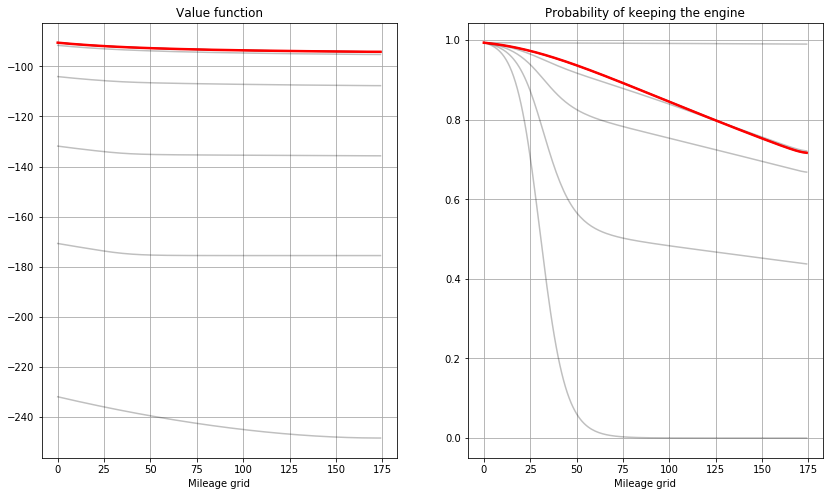

In [300]:
# Explore convergence of NK method
m = zurcher(beta=0.999,RC=5.0)
ev,pk = m.solve_show(maxiter=1000,solver='nk',tol=1e-10)
# ev,pk = m.solve_show(maxiter=1000,solver='vfi')

## Poly algorithm

- NK method may not be convergent at the initial point
- Successive apprizimataion (SA) iterations, however, are always convergent

**Poly algorithm** is combination of SA and NK:

1. Start with SA iterations
2. At approximately optimal time switch to NK iterations

## When to switch to NK iterations?

Suppose $EV_{k-1} = EV + C$ (where $EV$ is the fixed point)

$$
err_{k} = ||EV_{k-1}-EV_{k}|| = ||EV+C - T^*(EV+C)|| = ||EV + C - EV - \beta C|| = C (1-\beta)
$$

$$
err_{k+1} = ||EV_{k}-EV_{k+1}|| = ||T^*(EV+C) - T^*(T^*(EV+C))|| = ||EV + \beta C - EV - \beta^2 C|| = \beta C (1-\beta)
$$

- Then the ration of two errors $err_{k+1} \big/ err_{k} = \beta$ when the current apprximation is a constant away from the fixed point.

- NK iteration will immeditely "strip away" the constant

**Thus, switch to NK iteration when $err_{k+1} \big/ err_{k}$ is close to $\beta$**


In [ ]:
# Explore convergence of poly altorithm
m = zurcher(beta=0.95,RC=5.0)
polyset = {'verbose':True,
           'maxiter':1000,
           'tol':1e-12,
           'sa_min':5,
           'sa_max':10,
           'switch_tol':0.05,
          }
ev,pk = m.solve_poly(**polyset)
ev,pk = m.solve_show(maxiter=1000,solver='poly')

## Next: form the MLE estimator

- Embed the polyalgorithm into the optimization loop over the parameter $\theta$
- Use quasi-Newton method to maximize the likelihood
- BHHH is a great way to approximate the Hessian needed for numerical optimization
- Provide analytical derivatives of the likelihood w.r.t. paramters $\theta$
- Use implicit function theorem to compute the derivative of the fixed point w.r.t. paramters $\theta$
- Reuse the Frechet derivative of Bellman operator using the chain rule


<img src="_static/nfxp_manual.png" style="width:800px;">